In [1]:
import numpy as np
import scipy.optimize as opt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time

import MPO_hyperparameter_v2
import MPO_tt_v2
import MPO_inference_v2
import MPO_train_v2 as MPO

import activation_functions as act
import contractions as con

In [2]:
def weights_to_MPO(weights, D, sigma, sigma_prime, layer):
    # Reshape weights, order of indices are an assumption and may need to be modified
    MPO = []
    num_sites = len(sigma)
    starting_site = layer*(num_sites+1)  # +1 to skip bias

    for i in range(num_sites):
        # sigma'*D_right, D_left*sigma
        if i == 0:
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_right, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        elif i != 0 and i != num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, D, sigma[i]))
            # Need shape (D_left, D_right, sigma, sigma')
            site = np.transpose(site, (2, 1, 3, 0))
        elif i == num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_left, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        MPO.append(site)
    bias = weights[num_sites+starting_site]
    return MPO, bias

In [18]:
def FC2(MPO_0, bias_0, MPO_1, bias_1):
    data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
    
    start = time.time()

    temp = con.contract_horizontal(MPO_0[0], MPO_0[1], 'right')
    temp = con.contract_horizontal(temp, MPO_0[2], 'right')
    layer_0 = con.contract_horizontal(temp, MPO_0[3], 'right')

    temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
    temp = con.contract_horizontal(temp, MPO_1[2], 'right')
    layer_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

    end = time.time()

    total = 10000
    correct = 0
    for i in range(0, total):
        t0 = time.time()
        xW_1 = data.test.images[i] @ layer_0 + bias_0
        xW_1 = act.ReLU(xW_1)
        result = xW_1 @ layer_1 + bias_1
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    return correct/total*100, end-start

In [4]:
def close_legs(MPO):
    MPS = []
    for i, site in enumerate(MPO):
        if i == 0 or i == len(MPO)-1:
            site = np.reshape(site, (site.shape[0], site.shape[1]*site.shape[2])).T
        else:
            site = np.reshape(site, (site.shape[0], site.shape[1], site.shape[2]*site.shape[3]))
        MPS.append(site)
    return MPS

def open_legs(MPS, MPO_orig, bond_dim):
    MPO = []
    for i, site in enumerate(MPS):
        if i == 0 or i == len(MPS)-1:
            site = np.reshape(site.T, (bond_dim[i], MPO_orig[i].shape[1], MPO_orig[i].shape[2]))
        else:
            site = np.reshape(site, (bond_dim[i-1], bond_dim[i], MPO_orig[i].shape[2], MPO_orig[i].shape[3]))
        MPO.append(site)
    return MPO

In [5]:
import compression as comp
import metrics
import math
import matplotlib.pyplot as plt
import initializations as init
import canonical_forms as can

def initialize_random_MPS_changing_phys_dim(phys_dim, num_sites, bond_dim):
    MPS = []
    M_1 = np.random.rand(phys_dim[0], bond_dim)
    MPS.append(M_1)
    for i in range(1, num_sites-1):
        M_i = np.random.rand(bond_dim, bond_dim, phys_dim[i])
        MPS.append(M_i)
    M_N = np.random.rand(phys_dim[-1], bond_dim)
    MPS.append(M_N)
    #MPS = [M_1] + [M_i]*(num_sites-2) + [M_N]
    MPS, _ = can.left_normalize(MPS)
    MPS, _ = can.right_normalize(MPS)
    return MPS

def compress_NN(raw_state, phys_dim, threshold, compressed_state=0, plot=0):
    """ Right normalizes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

    Args:
        raw_state: MPS to be compressed
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    compressed_state = initialize_random_MPS_changing_phys_dim(phys_dim, num_sites=len(raw_state), bond_dim=1)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]
    max_bond_dim = 1
    # compressed_state = init.initialize_random_normed_state_MPS(len(raw_state),
    #                                                             bond_dim=max_bond_dim,
    #                                                             phys_dim=raw_state[0].shape[0])
    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.scalar_product(compressed_state, raw_state))
    best_dist = []
    best_sim = []
    compressions = []
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.scalar_product(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            best_dist.append((metrics.overlap(compressed_state, raw_state)))
            best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", best_sim[-1], "Dist:", best_dist[-1], "BondDim:", max_bond_dim)
            compressions.append(compressed_state[:])

            # Break if we cannot increase bond dimension anymore
            if max_bond_dim+1 == bond_dim_raw_state:
                break

            # Break if changing bond dimension did not do enough
            if len(best_dist) > 1 and np.abs(best_dist[-2]-best_dist[-1] < threshold):
                break

            # Update each tensor by increasing bond dimension
            for i, tensor in enumerate(compressed_state):
                if tensor.ndim == 2:
                    new_tensor = np.zeros((tensor.shape[0], tensor.shape[1]+1))
                    new_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
                    compressed_state[i] = new_tensor

                elif tensor.ndim == 3:
                    new_tensor = np.zeros((tensor.shape[0]+1, tensor.shape[1]+1, tensor.shape[2]))
                    new_tensor[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
                    compressed_state[i] = new_tensor
            max_bond_dim = compressed_state[math.ceil(len(compressed_state)/2)].shape[0]

    if plot == 1:
        max_bond_dim = range(1, len(best_dist)+1)

        plt.figure()
        plt.title("Euclidean Distance vs. Max Bond Dimension")
        plt.xlabel("Max Bond Dimension")
        plt.ylabel("Euclidean Distance")
        plt.plot(max_bond_dim, best_dist)

    return compressions, best_dist, best_sim

In [6]:
def calculate_params(data):
    params = 0
    for tensor in data:
        params += tensor.size

    return params

# Pre-processing

## 1. Train

In [7]:
D = 8
threshold = 90

In [8]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
all_weights = []
for bond_dim in range(2, D+1):
    weights = MPO.main(r_1=bond_dim, r_2=bond_dim)
    all_weights.append(weights)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Guessing
After 0 trainning step(s),best accuracy=0
Accuracy at step 0: 0.1121
Accuracy at step 1: 0.1424
Accuracy at step 2: 0.1645
Accuracy at step 3: 0.1798
Accuracy at step 4: 0.2155
Accuracy at step 6: 0.2801
Accuracy at step 8: 0.3165
Accuracy a

## 2. Open weights matrices into correct MPO

In [9]:
class Model:
    def __init__(self, weights, bond_dim):
        self.weights = weights
        self.MPO_0, self.bias_0 = weights_to_MPO(weights, bond_dim, sigma=[4, 7, 7, 4], sigma_prime=[4, 4, 4, 4], layer=0)
        self.MPO_1, self.bias_1 = weights_to_MPO(weights, bond_dim, sigma=[4, 4, 4, 4], sigma_prime=[1, 10, 1, 1], layer=1)
        self.MPS_0 = close_legs(self.MPO_0)
        self.MPS_1 = close_legs(self.MPO_1)

        self.compressed_MPS_0, _, _ = compress_NN(self.MPS_0, phys_dim=[16, 28, 28, 16], threshold=1e-8, plot=0)
        self.compressed_MPS_1, _, _ = compress_NN(self.MPS_1, phys_dim=[4, 40, 4, 4], threshold=1e-8, plot=0)

## 3. Check that MPO is correct based on accuracy from model

In [14]:
all_models = []
for i in range(2, D+1):
    all_models.append(Model(all_weights[i-2], bond_dim=i))

Sim: 570.4856988007951 Dist: 34.86929619054857 BondDim: 1
Sim: 10.57940341403695 Dist: 5.776149787695831 BondDim: 1
Sim: 141.84897238950475 Dist: 32.89038601862625 BondDim: 1
Sim: 546.3290180531081 Dist: 26.024938939229845 BondDim: 2
Sim: 7.560964093885225 Dist: 5.857366396795585 BondDim: 1
Sim: 26.180312833683015 Dist: 3.9609837624651165 BondDim: 2
Sim: 183.0365727891839 Dist: 49.62488487336964 BondDim: 1
Sim: 899.220391062254 Dist: 41.79049390019364 BondDim: 2
Sim: 1788.346762567223 Dist: 29.28001039817357 BondDim: 3
Sim: 14.158360284380178 Dist: 7.228385222415006 BondDim: 1
Sim: 35.16231579486146 Dist: 5.589776150540051 BondDim: 2
Sim: 53.36833176939428 Dist: 3.6110360616606316 BondDim: 3
Sim: 283.6744061392797 Dist: 57.81572759667213 BondDim: 1
Sim: 1257.7267488316036 Dist: 48.66832660817784 BondDim: 2
Sim: 2174.8711539027972 Dist: 38.0980525718714 BondDim: 3
Sim: 3071.7995892148065 Dist: 23.548528074108347 BondDim: 4
Sim: 18.252483009417702 Dist: 6.908641030233461 BondDim: 1
Sim: 

In [19]:
for model in all_models:
    acc, t = FC2(model.MPO_0, model.bias_0, model.MPO_1, model.bias_1)
    print(acc, "%", t, "s")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
88.14999999999999 % 0.0019943714141845703 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
88.12 % 0.0019943714141845703 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
92.61 % 0.0029909610748291016 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.67999999999999 % 0.0029914379119873047 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Ex

In [20]:
for model in all_models:
    orig = calculate_params(model.MPS_0) + calculate_params(model.MPS_1)
    print("Orig:", orig)
    for i in range(len(model.compressed_MPS_0)):
        compressed = calculate_params(model.compressed_MPS_0[i]) + calculate_params(model.compressed_MPS_1[i])
        print(i+1, round(compressed/orig*100, 2), "% of Orig")

Orig: 480
1 29.17 % of Orig
Orig: 1020
1 13.73 % of Orig
2 47.06 % of Orig
Orig: 1760
1 7.95 % of Orig
2 27.27 % of Orig
3 57.95 % of Orig
Orig: 2700
1 5.19 % of Orig
2 17.78 % of Orig
3 37.78 % of Orig
4 65.19 % of Orig
Orig: 3840
1 3.65 % of Orig
2 12.5 % of Orig
3 26.56 % of Orig
4 45.83 % of Orig
5 64.38 % of Orig
Orig: 5180
1 2.7 % of Orig
2 9.27 % of Orig
3 19.69 % of Orig
4 33.98 % of Orig
5 47.72 % of Orig
6 63.63 % of Orig
Orig: 6720
1 2.08 % of Orig
2 7.14 % of Orig
3 15.18 % of Orig
4 26.19 % of Orig
5 36.79 % of Orig
6 49.05 % of Orig
7 62.98 % of Orig


# Accuracy Tests

## 1. Check accuracy for each compressed dimension

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

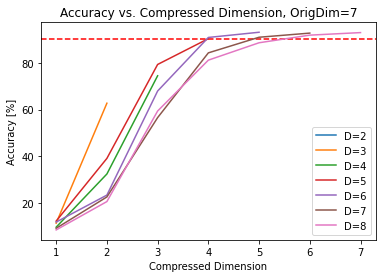

In [21]:
plt.figure()
plt.xlabel('Compressed Dimension')
plt.ylabel('Accuracy [%]')
plt.axhline(threshold, color='r', linestyle='--')

plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(model.compressed_MPS_0)))

for model in all_models:
    ### Maximizing total accuracy
    acc_compressed = []
    time_compressed = []
    params = []
    if len(model.compressed_MPS_0) > len(model.compressed_MPS_1):
        shortest = len(model.compressed_MPS_1)
        longest = len(model.compressed_MPS_0)
    else:
        shortest = len(model.compressed_MPS_0)
        longest = len(model.compressed_MPS_1)

    for new_dim in range(1, longest+1):
        if new_dim < shortest:
            MPS_0_test = model.compressed_MPS_0[new_dim-1]
            MPS_1_test = model.compressed_MPS_1[new_dim-1]
        else:
            if shortest == len(model.compressed_MPS_0):
                MPS_0_test = model.compressed_MPS_0[-1]
                MPS_1_test = model.compressed_MPS_1[new_dim-1]
            elif shortest == len(model.compressed_MPS_1):
                MPS_0_test = model.compressed_MPS_0[new_dim-1]
                MPS_1_test = model.compressed_MPS_1[-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, model.MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, model.MPO_1, bond_dim=dim_1)

        total_params = 0
        for tensor in MPO_0_test:
            total_params += tensor.size
        for tensor in MPO_1_test:
            total_params += tensor.size
        params.append(total_params)

        acc, t = FC2(MPO_0_test, model.bias_0, MPO_1_test, model.bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)

    params_orig = 0
    for tensor in model.MPO_0:
        params_orig += tensor.size
    for tensor in model.MPO_1:
        params_orig += tensor.size

    params = np.array(params)/params_orig*100
    acc_orig, time_orig = FC2(model.MPO_0, model.bias_0, model.MPO_1, model.bias_1)


    x = range(1, len(model.compressed_MPS_0)+1)
    data1 = acc
    data2 = params

 
    plt.plot(x, acc_compressed, label="D=%d" % (len(model.compressed_MPS_0)+1))


plt.legend()

    # plt.figure()
    # plt.plot(x, time_compressed)
    # plt.title('Contraction Time vs. Compressed Dimension')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Compressed Dimension')
    # plt.axhline(time_orig, color='r', linestyle='--')

## 2. Check accuracy when compressing one layer at a time

In [28]:
# ### Check changes in W1 for constant W0
# plt.figure()
# for W0_dim in range(1, len(compressed_MPS_0)+1):
#     acc_compressed = []
#     time_compressed = []
#     MPS_0_test = compressed_MPS_0[W0_dim-1]
#     for W1_dim in range(1, len(compressed_MPS_1)+1):
#         MPS_1_test = compressed_MPS_1[W1_dim-1]

#         dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
#         dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
#         MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
#         MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

#         acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
#         acc_compressed.append(acc)
#         time_compressed.append(t)

#     acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
#     plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W0_dim=%d" % W0_dim)
#     plt.axhline(threshold, color='r', linestyle='--')
#     plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
#     plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)+1))
#     plt.xlabel('Compressed Dimension W1')
#     plt.ylabel('Accuracy [%]')

In [29]:
# ### Check changes in W0 for constant W1
# plt.figure()
# for W1_dim in range(1, len(compressed_MPS_1)+1):
#     acc_compressed = []
#     time_compressed = []
#     MPS_1_test = compressed_MPS_1[W1_dim-1]
#     for W0_dim in range(1, len(compressed_MPS_0)+1):
#         MPS_0_test = compressed_MPS_0[W0_dim-1]

#         dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
#         dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
#         MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
#         MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

#         acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
#         acc_compressed.append(acc)
#         time_compressed.append(t)


#     acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
#     plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W1_dim=%d" % W1_dim)
#     plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
#     plt.axhline(threshold, color='r', linestyle='--')
#     plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_1)+1))
#     plt.xlabel('Compressed Dimension W0')
#     plt.ylabel('Accuracy [%]')

## 3. Heatmap of accuracy by layer dimension

In [44]:
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
acc_matrix = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_array = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, _ = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_array.append(acc)
    acc_matrix.append(acc_array)
# fig, ax = plt.subplots()
# im = ax.imshow(acc_matrix, cmap='inferno_r')

# # We want to show all ticks...
# ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
# ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# # ... and label them with the respective list entries
# ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
# ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# # Rotate the tick labels and set their alignment.
# # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
# #          rotation_mode="anchor")

# plt.xlabel('W0 Dimension')
# plt.ylabel('W1 Dimension')
# plt.title('Loss vs. Compressed Dimensions, OrigDim=%d' % D)
# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(acc_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

## 4. Compression ratio for layer dimensions

In [45]:
orig_params = calculate_params(MPS_0)+calculate_params(MPS_1)
params_matrix = []
compression_ratio_matrix = []
for i in range(len(compressed_MPS_0)):
    compression_ratio = []
    for j in range(len(compressed_MPS_1)):
        params = calculate_params(compressed_MPS_0[i]) + calculate_params(compressed_MPS_1[j])
        compression_ratio.append(round(params/orig_params*100, 2))
    compression_ratio_matrix.append(compression_ratio)

# fig, ax = plt.subplots()
# im = ax.imshow(compression_ratio_matrix, cmap='inferno_r')

# ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
# ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
# ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# plt.xlabel('W0 Dimension')
# plt.ylabel('W1 Dimension')
# plt.title('Compression Ratio vs. Compressed Dimensions, OrigDim=%d' % D)

# # Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 5. Compression ratio for accuracy above threshold 

Best Compression: 62.98 %
W0_dim =  7
W1_dim =  7


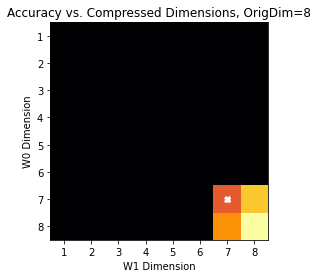

In [48]:
compression_ratio_plot = np.array(compression_ratio_matrix[:])
acc_matrix_plot = np.array(acc_matrix[:])
compression_ratio_plot[acc_matrix_plot < threshold] = 0

fig, ax = plt.subplots()
im = ax.imshow(compression_ratio_plot, cmap='inferno')
ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Accuracy vs. Compressed Dimensions, OrigDim=%d' % D)
try:
    minval = np.min(compression_ratio_plot[np.nonzero(compression_ratio_plot)])
    ij = np.where(compression_ratio_plot == minval)
    plt.plot(ij[1], ij[0], 'wX')
    print("Best Compression:", minval, "%")
    print("W0_dim = ", ij[0][0]+1)
    print("W1_dim = ", ij[1][0]+1)
except:
    print("Layers cannot be compressed and still reach given threshold")


# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 6. Dependence of accuracy on compression

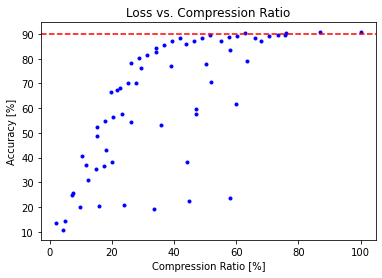

In [47]:
sorted_comp = np.array(compression_ratio_matrix[:])
sorted_acc = np.array(acc_matrix[:])
sorted_comp = np.reshape(sorted_comp, sorted_comp.size)
sorted_acc = np.reshape(sorted_acc, sorted_acc.size)
sorted_comp, sorted_acc = zip(*sorted(zip(sorted_comp, sorted_acc)))

plt.plot(sorted_comp, sorted_acc, 'b.')

plt.title("Loss vs. Compression Ratio")
plt.xlabel("Compression Ratio [%]")
plt.ylabel("Accuracy [%]")
plt.axhline(threshold, color='r', linestyle='--')

In [ ]:
def vector_to_left_canonical_MPS_NN(tensor, phys_dim):
    """ Decomposes a vector of length d^L (phys_dim^num_sites) into a
        left-canonical MPS. Final site will not be canonical due to
        original norm

    Args:
        tensor: Vector of length that can be described by d^L (Ex: 512 = 2^9)
        phys_dim: Physical dimension necessary on MPS at each site (d)
        num_sites: Number of sites necessary (L)

    Returns:
        A_tensors: Left canonical form of input MPS
    """

    A_tensors = []
    num_sites = len(phys_dim)
    for i in range(0, num_sites-1):
        # Remove one leg such that tensor has shape (d, d^(L-1)) with L sites
        if i == 0:
            reshaped_tensor = np.reshape(tensor, (phys_dim[i],
                                                  tensor.shape[0]//phys_dim[i]))
        else:
            reshaped_tensor = np.reshape(tensor, (A_tensors[-1].shape[1]*phys_dim[i],
                                                  tensor.shape[1]//phys_dim[i]))       
        #print("Reshape:", reshaped_tensor.shape)

        # SVD and save the rank for the next iteration of the loop
        U, S_vector, V = np.linalg.svd(reshaped_tensor, full_matrices=False)
        rank = len(S_vector)

        if i == 0:
            # No need to reshape since U is already a left-canonical matrix
            A_tensors.append(U)
        else:
            # Break apart first leg of U into a left bond dimension
            # and physical dimension
            U = np.reshape(U, (A_tensors[-1].shape[1], phys_dim[i], U.shape[1]))
            # Transpose so that we have the correct shape
            # (left bond, right bond, physical dimension)
            U = np.transpose(U, (0, 2, 1))
            A_tensors.append(U)

        # We recreate the tensor with the remaining legs
        tensor = np.diag(S_vector) @ V
    # Final A tensor is the remaining tensor after all other legs removed
    A_tensors.append(tensor)

    return A_tensors

In [ ]:
data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
x_MPS = vector_to_left_canonical_MPS_NN(data.test.images[0], phys_dim=[4, 7, 7, 4])

# Proof that MPO structure is only used for storage

In [ ]:
def FC2_MPO(MPO_0, bias_0, MPO_1, bias_1):
    data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
    

    start = time.time()

    end = time.time()

    total = 1000
    correct = 0
    for i in range(0, total):
        xW = []
        # Decompose input into an MPS
        x_MPS = vector_to_left_canonical_MPS_NN(data.test.images[i], phys_dim=[4, 7, 7, 4])
        # Contract into W0
        for i in range(len(x_MPS)):
            site = con.contract_vertical(x_MPS[i], MPO_0[i], 'up')
            xW.append(site)

        # Site-wise ReLU (DOES NOT WORK)
        # for site in xW:
        #     site = act.ReLU(site)

        # Contract xW0 into a matrix
        site = con.contract_horizontal(xW[0].T, xW[1], 'right')
        site = con.contract_horizontal(site, xW[2], 'right')
        xW_matrix = con.contract_horizontal(site, xW[3].T, 'right')

        # Full-Matrix ReLU (DOES NOT WORK)
        xW_matrix = act.ReLU(xW_matrix)

        temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
        temp = con.contract_horizontal(temp, MPO_1[2], 'right')
        W_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

        result = xW_matrix @ W_1 # + bias_1
        #print(result)
        #print(list(data.test.labels[i]).index(1))
        index = np.abs(result).argmin()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    return correct/total*100, end-start

In [ ]:
# 1. Decompose input vector into an MPS
FC2_MPO(MPO_0, bias_0, MPO_1, bias_1)